# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%env CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
%env CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
%env CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
%env CHRONOSTRAIN_CACHE_DIR=./cache
%env CHRONOSTRAIN_LOG_INI=./logging.ini
%env JAX_PLATFORM_NAME=cpu


from typing import *
from pathlib import Path
import numpy as np
import jax
import pandas as pd

from chronostrain.config import cfg
from chronostrain.database import *
from chronostrain.inference import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as patches
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
import string
import seaborn as sb

from Bio import Phylo
from helpers import *

env: CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
env: CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
env: CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
env: CHRONOSTRAIN_CACHE_DIR=./cache
env: CHRONOSTRAIN_LOG_INI=./logging.ini
env: JAX_PLATFORM_NAME=cpu


In [105]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Annotation functions

In [41]:
def annotate_phylogroups(db: StrainDatabase, phylogroup_path: Path):
    """To each strain, add a phylogroup annotation."""
    for strain in db.all_strains():
        strain.phylogroup = '?'
    
    with open(phylogroup_path, 'r') as f:
        for line in f:
            tokens = line.strip().split('\t')
            accession = Path(tokens[0]).with_suffix('').with_suffix('').name
            phylogroup = tokens[4]
            try:
                db.get_strain(accession).phylogroup = phylogroup
            except QueryNotFoundError:
                pass
    

def create_palette(db: StrainDatabase):
    palette_tab20 = sb.color_palette("tab20", 20)
    phylogroup_colors = {
        'A': palette_tab20[4],
        'B1': palette_tab20[1],
        'B2': palette_tab20[6],
        'C': palette_tab20[0],
        'D': 'gold',
        'E': palette_tab20[8],
        'F': palette_tab20[7],
        'G': palette_tab20[5],
        'fergusonii': palette_tab20[2],
        'albertii': palette_tab20[3],
        'E or cladeI': palette_tab20[9],
        'cladeI': palette_tab20[10],
        'Unknown': palette_tab20[11],
        'cladeV': palette_tab20[12],
        '?': np.array([0.0, 0.0, 0.0, 1.0])
    }
    strain_colors = {
        s.id: phylogroup_colors[s.phylogroup]
        for s in db.all_strains()
    }
    return phylogroup_colors, strain_colors


def add_figure_labels(fig, axes, labels=None):
    """ add A/B/C/D labels """
    if labels is None:
        labels = [string.ascii_lowercase[n] for n in range(len(axes))]
    if len(labels) != len(axes):
        raise Exception("There must be one label per axis.")
        
    for n, _ax in enumerate(axes):
        label = labels[n]
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
        _ax.text(0, 1, label, transform=_ax.transAxes + trans,
                 va='bottom', fontfamily='sans-serif', weight='bold', size=15)

# Dataframe Loading

In [40]:
def load_abx_df(umb_id) -> pd.DataFrame:
    abx_df = pd.read_csv(Path().resolve().parent / 'files' / 'abx_table.tsv', sep="\t").astype(
        dtype={
            'experiment_day_ended': 'int64',
            'date_ended': 'datetime64[ns]'
        }
    )
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']

    abx_df = abx_df.merge(umb_dates, left_on='patient_id', right_on='ID')
    abx_df['experiment_day_ended'] = (abx_df['date_ended'] - abx_df['ref_date']).dt.days + abx_df['ref_days']
    abx_df = abx_df[['patient_id', 'raw_abx', 'clean_abx', 'abx_class', 'date', 'days_before', 'weeks_before', 'date_ended', 'experiment_day_ended']]
    return abx_df.loc[abx_df['patient_id'] == umb_id]


def load_uti_df(umb_id) -> pd.DataFrame:
    uti_df = pd.read_csv(Path().resolve().parent / 'files' / 'utis.csv').astype({'UTIDate': 'datetime64[ns]'})
    uti_df = uti_df.loc[uti_df['Patient'] == umb_id]
    
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']
    
    uti_df = uti_df.merge(umb_dates, left_on='Patient', right_on='ID')
    uti_df['UTIDay'] = (uti_df['UTIDate'] - uti_df['ref_date']).dt.days + uti_df['ref_days']
    uti_df = uti_df[['Patient', 'UTIDate', 'UTIDay']]
    
    return uti_df


def load_sample_df(umb_id) -> pd.DataFrame:
    df = pd.read_csv(Path().resolve().parent / 'files' / "umb_samples.csv", sep=',').astype({
        'date': 'datetime64[ns]'
    })
    df['T'] = df['days']
    return df.loc[df['ID'] == umb_id, ['Run', 'ID', 'SampleName', 'date', 'Group', 'type', 'T']]

In [39]:
def load_fastmlst_df(fastmlst_path: Path) -> pd.DataFrame:
    df_entries = []
    with open(fastmlst_path, "rt") as f:
        for line in f:
            tokens = line.rstrip().split("\t")
            strain_id = tokens[0]
            
            species_mlst_tokens = tokens[1].split("#")
            if len(species_mlst_tokens) > 1:
                fastmlst_taxonomy = species_mlst_tokens[0]
                schema_version = species_mlst_tokens[1]
            elif len(species_mlst_tokens) == 1:
                fastmlst_taxonomy = species_mlst_tokens[0]
                schema_version = "?"
            else:
                raise ValueError("Don't know how to parse species MLST schema name `{}`.".format(tokens[1]))
                                 
            if schema_version == '?':
                species_mlst_id = "ST{}".format(tokens[2])
            else:
                if fastmlst_taxonomy == 'ecoli':
                    assert schema_version == "1"  # Assert fastMLST has used Achtmann scheme.
                    species_mlst_id = "ST{}".format(tokens[2])
                else:
                    species_mlst_id = "ST{}:{}".format(schema_version, tokens[2])
            df_entries.append({
                'StrainId': strain_id,
                'MLST_Tax': fastmlst_taxonomy,
                'MLST': species_mlst_id
            })
    return pd.DataFrame(df_entries)


mlst_df = load_fastmlst_df(Path("/mnt/e/ecoli_db/fastmlst/fastmlst.tsv"))
print("# fastMLST entries: {}".format(mlst_df.shape[0]))
mlst_df

# fastMLST entries: 2063


,StrainId,MLST_Tax,MLST
0,NC_000913.3,ecoli,ST10
1,NC_002695.2,ecoli,ST11
2,NC_004431.1,ecoli,ST73
3,NC_007779.1,ecoli,ST10
4,NC_007946.1,ecoli,ST95
...,...,...,...
2058,NZ_LT903847.1,ecoli,ST15
2059,NZ_LT906474.1,ecoli,ST1721
2060,NZ_OU342919.1,ecoli,ST1308
2061,NZ_OU701449.1,ecoli,ST38


# Annotation preprocessing

In [42]:
db = cfg.database_cfg.get_database()
annotate_phylogroups(db, phylogroup_path=Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt"))
clades = [
    "A", "B1", "B2", "C", "D", "E", "F", "G", 
    "fergusonii", "albertii", "E or cladeI", "cladeI", "Unknown", "cladeV",
    "N/A"
]
phylo_colors, strain_colors = create_palette(db)

abx_acronym = {'nitrofuran': 'N', 'fluoroquinolone': 'F', 'beta_lactam': 'B', 'sulfonamide': 'S', 'macrolide': 'M', 'tetracycline': 'T'}
abx_colors = {'nitrofuran': 'red', 'fluoroquinolone': 'magenta', 'beta_lactam': 'green', 'sulfonamide': 'blue', 'macrolide': 'cyan', 'tetracycline': 'orange'}
abx_labels = {'nitrofuran': 'Nitrofurantoin', 'fluoroquinolone': 'Fluoroquinolone', 'beta_lactam': 'Beta Lactam', 'sulfonamide': 'Sulfonamide', 'macrolide': 'Macrolide', 'tetracycline': 'Tetracycline'}

In [43]:
base_dir = Path("/data/cctm/youn/umb")
# bf_threshold = 19000.0
# prior_p = 0.001
posterior_threshold = 0.95
print("Using posterior threshold =", posterior_threshold)

# What is the probability threshold?
# _x = bf_threshold * (prior_p / (1 - prior_p))
# p_threshold = _x / (_x + 1)
# print("BF threshold = {} // p threhsold = {}".format(bf_threshold, p_threshold))


metadata_df = pd.read_csv(Path("/home/youn/work/chronostrain/examples/umb/files/umb_samples.csv"))

Using posterior threshold = 0.95


# Load inference result

In [23]:
# ====== Load results
results = {
    100.0: (
        ChronostrainResult(
            'UMB18_100pct',
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'stool' / 'UMB18' / 'chronostrain_100pct', 
            base_dir / 'stool' / 'UMB18' / 'filtered' / 'filtered_reads.csv',
            posterior_threshold=posterior_threshold
        ),
        Path('/mnt/e/ecoli_db/chronostrain_files/ecoli.100pct.txt'),
        r'$1 - 10^{-10}$'
    ),
    # 99.95: (
    #     ChronostrainResult(
    #         'UMB18_99.95pct',
    #         db, 
    #         GaussianStrainCorrelatedWithGlobalZerosPosterior,
    #         base_dir / 'stool' / 'UMB18' / 'chronostrain_99_95pct', 
    #         base_dir / 'stool' / 'UMB18' / 'filtered' / 'filtered_reads.csv',
    #         posterior_threshold=posterior_threshold
    #     ),
    #     Path('/mnt/e/ecoli_db/chronostrain_files/ecoli.99_95pct.txt')
    # ),
    99.8: (
        ChronostrainResult(
            'UMB18_99.8pct',
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'stool' / 'UMB18' / 'chronostrain', 
            base_dir / 'stool' / 'UMB18' / 'filtered' / 'filtered_reads.csv',
            posterior_threshold=posterior_threshold
        ),
        Path('/mnt/e/ecoli_db/chronostrain_files/ecoli.clusters.txt'),
        '0.998'
    ),
    # 98.0: (
    #     ChronostrainResult(
    #         'UMB18_98pct',
    #         db, 
    #         GaussianStrainCorrelatedWithGlobalZerosPosterior,
    #         base_dir / 'stool' / 'UMB18' / 'chronostrain_98pct', 
    #         base_dir / 'stool' / 'UMB18' / 'filtered' / 'filtered_reads.csv',
    #         posterior_threshold=posterior_threshold
    #     ),
    #     Path('/mnt/e/ecoli_db/chronostrain_files/ecoli.98pct.txt')
    # ),
}

70 of 2745 inference strains passed Posterior p(Z_s|Data) > 0.95
57 of 1667 inference strains passed Posterior p(Z_s|Data) > 0.95


# Custom renderer

In [123]:
from matplotlib.pyplot import Axes
import matplotlib.transforms as transforms
from Bio.Nexus.Trees import Tree
from Bio.Phylo.Newick import Clade

class ChronostrainRendererCustom:
    def __init__(
            self, 
            db: StrainDatabase,
            abund_lb: float, 
            target_taxon: Taxon, 
            strain_palette: Dict[str, np.ndarray],
            stool_result: ChronostrainResult,
            urine_result: ChronostrainResult,
            cluster_path: Path,
            plate_results: List[Tuple[float, ChronostrainResult]],
            abx_df: pd.DataFrame,
            abx_palette: Dict[str, np.ndarray],
            abx_label: Dict[str, str],
            uti_df: pd.DataFrame,
            sample_df: pd.DataFrame,
            mlst_df: pd.DataFrame,
            cluster_name_prefix: str = 'CS'
    ):
        self.abund_lb = abund_lb
        self.db = db
        self.target_taxon = target_taxon
        self.strain_palette = strain_palette
        self.stool_result = stool_result
        self.urine_result = urine_result
        self.plate_results = plate_results
        self.abx_df = abx_df
        self.abx_label = abx_label
        self.abx_palette = abx_palette
        self.uti_df = uti_df
        self.sample_df = sample_df
        self.clustering = {}
        self.cluster_names = {}
        with open(cluster_path, "rt") as f:
            _next_cluster_number = 1
            for line in f:
                if line.startswith("#"):
                    continue
                tokens = line.strip().split('\t')
                s_rep = tokens[0]
                # ========= assign cluster anonymized naming
                self.cluster_names[s_rep] = f'{cluster_name_prefix}{_next_cluster_number}'
                _next_cluster_number += 1
                
                # ========= store cluster member IDs
                if len(tokens) > 1:
                    s_members = tokens[1].split(",")
                    self.clustering[s_rep] = s_members
                else:
                    s_members = []
                    self.clustering[s_rep] = s_members

        self.mlst_df = mlst_df
        t_mins = [np.min(self.stool_result.time_points)]
        if self.urine_result is not None:
            t_mins.append(np.min(self.urine_result.time_points))
        self.min_t = np.min(t_mins)

    def get_merged_df(self):
        dfs = [
            self.stool_result.annot_df_with_lower_bound(self.abund_lb, target_taxon=self.target_taxon).assign(Src='stool')
        ]
        if self.urine_result is not None:
            dfs.append(
                self.urine_result.annot_df_with_lower_bound(self.abund_lb, target_taxon=self.target_taxon).assign(Src='urine')
            )
        for t, plate_result in self.plate_results:
            dfs.append(
                plate_result.annot_df_with_lower_bound(self.abund_lb, target_taxon=self.target_taxon).assign(
                    Src='plate',
                    T=t
                )
            )
        df_all = pd.concat(dfs, ignore_index=True)
        if self.mlst_df.shape[0] > 0:
            df_all = df_all.merge(self.mlst_df, on='StrainId', how='left')  # only attach MLST annotations if available.
        else:
            df_all['MLST'] = None
        return df_all
        
    def get_color(self, strain_id: str) -> np.ndarray:
        return self.strain_palette[strain_id]

    def plot_overall_relabund(
            self,
            ax: Axes,
            strain_linestyles: Dict = {},
            mode: str = 'stool',
            yscale: str = 'log'
    ) -> Tuple[float, float]:
        if mode == 'stool':
            res = self.stool_result
        elif mode == 'urine':
            res = self.urine_result
        else:
            raise ValueError(f"Unknown plotting mode `{mode}`.")
        df = res.annot_df_with_lower_bound(self.abund_lb, target_taxon=self.target_taxon)
        if df.shape[0] == 0:
            return [0.1, 1.0]

        overall_relabund = res.overall_ra()
        
        ymin = 1.0  # max possible value
        ymax = 0.0  # min possible value
        for s_idx in pd.unique(df['StrainIdx']):
            s_id = res.display_strains[s_idx].id
            
            section = overall_relabund[:, :, s_idx]
            color = self.get_color(s_id)
            upper = np.quantile(section, axis=-1, q=0.975)
            lower = np.quantile(section, axis=-1, q=0.025)
            median = np.quantile(section, axis=-1, q=0.5)
            if s_id in strain_linestyles:
                _style = strain_linestyles[s_id]
                ax.plot(res.time_points, median, marker='.', linewidth=2, color=color, **_style)
            else:
                ax.plot(res.time_points, median, marker='.', linewidth=2, color=color)
            ax.fill_between(res.time_points, lower, upper, color=color, alpha=0.3)
            ymin = min(ymin, np.min(median))
            ymax = max(ymax, np.max(median))
        ax.set_yscale(yscale)
        ax.set_xticks(res.time_points)
        return ymin, ymax

    def get_plotted_strain_names(self, res: ChronostrainResult) -> Dict[str, str]:
        df = res.annot_df_with_lower_bound(self.abund_lb, target_taxon=self.target_taxon)
        return {
            row['StrainId']: row['StrainName']
            for _, row in df.iterrows()
        }

    def plot_tree(
            self,
            ax: Axes,
            tree: Tree,
    ) -> Tuple[Dict, Dict]:
        strain_id_to_names = {
            # row['StrainId']: row['StrainName']
            row['StrainId']: '{}:{} ({})'.format(
                self.cluster_names[row['StrainId']],
                row['MLST'],
                len(self.clustering[row['StrainId']])
            )
            for _, row in self.get_merged_df().iterrows()
        }

        strain_id_colors = {
            row['StrainId']: (
                phylo_colors[db.get_strain(row['StrainId']).phylogroup]
            )
            for _, row in self.get_merged_df().iterrows()
        }
        
        return plot_subtree(ax, strain_id_to_names, strain_id_colors, tree, [])
    
    def plot_abx(self, ax: Axes, draw_labels: bool = True):
        for _, row in self.abx_df.iterrows():
            d = row['experiment_day_ended']
            if d < self.min_t:
                continue
                
            abx_class = row['abx_class']
            abx_label = self.abx_label.get(abx_class, '?')
                
            color = self.abx_palette.get(abx_class, 'gray')
            ax.axvline(x=d, color=color, linestyle='--', zorder=1)
            if draw_labels:
                ax.text(
                    x=d, 
                    y=1.01, 
                    s=abx_label, 
                    color=color,
                    transform=transforms.blended_transform_factory(ax.transData, ax.transAxes), 
                    horizontalalignment='center', verticalalignment='bottom'
                )
                
    def plot_infections(self, ax: Axes, color='black'):
        for _, row in self.uti_df.iterrows():
            d = row['UTIDay']
            ax.axvline(x=d, color=color, alpha=1.0, zorder=1)

    def set_xtick_times(self, ax: Axes):
        """
        read from the UMB experiment dataframe and change x-axis labels to the sample dates.
        """
        xticks = []
        xlabels = []
        prev_t = -10000
        start_t = int(np.min(self.sample_df['T']))
        for _, row in self.sample_df.groupby('T').head(1).sort_values('T').iterrows():
            date = row['date']
            samplename = row['SampleName']
            t = row['T']

            day_number = int(t - start_t)
            lbl_t = f'{day_number}'
            if t - prev_t < 7:  # Within a week
                xticks.append(t)
                xlabels.append("")
                # xlabels[-1] = lbl_t
            else:
                xticks.append(t)
                xlabels.append(lbl_t)
            prev_t = t
        t_min = self.sample_df['T'].min()
        t_max = self.sample_df['T'].max()
        dt = (t_max - t_min) * 0.02
        ax.set_xlim(
            left=t_min - dt,
            right=t_max + dt
        )
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels, rotation=90)


def plot_subtree(
    ax: Axes,
    strain_id_to_names: Dict[str, str],
    strain_id_colors: Dict[str, np.ndarray],
    tree: Tree,
    subtrees_with_colors: List[Tuple[List[str], np.ndarray]]
) -> Tuple[Dict, Dict]:
    ax.axis('off')

    strain_leaves = set(strain_id_to_names.keys())
    if len(strain_leaves) == 0:
        return {}, {}

    subtree = pruned_subtree(tree, strain_leaves)
    if isinstance(subtree, Clade) and subtree.is_terminal():
        return {subtree: 0}, {subtree: 0}
    
    def color_fn(s):
        if s.is_terminal() and len(s.name) != 0:
            return strain_id_colors[s.name]
        else:
            return "black"
    def label_fn(s):
        if s.is_terminal() and len(s.name) != 0:
            return "{}".format(
                strain_id_to_names[s.name]
            )
            # return "{} [{}]".format(
            #     strain_id_to_names[s.name], 
            #     ' | '.join(self.db.get_strain(x).name for x in self.clustering[s.name])
            #     # len(self.clustering[s.name])
            # )
        else:
            return ""

    node_markers = {}
    node_labels = {}
    for clust, style in subtrees_with_colors:
        anc = tree.common_ancestor(clust)
        if anc in node_markers:
            node_markers[anc] += [style]
        else:
            node_markers[anc] = [style]
        node_labels[anc] = ''
        
    x_posns, y_posns = phylo_draw_custom(
        subtree, 
        label_func=label_fn,
        axes=ax,
        do_show=False,
        show_confidence=False,
        label_colors=color_fn,
        internal_node_markers=node_markers,
        branch_labels=lambda c: '' #lambda c: '{:.03f}'.format(c.branch_length) if (c.branch_length is not None and c.branch_length > 0.003) else ''
    )
    return x_posns, y_posns

# Plotting code

## style definitions

In [25]:
index_df = pd.read_csv("/mnt/e/ecoli_db/ref_genomes/index.tsv", sep="\t")
# index_df.loc[index_df['Accession'].isin(strain_ids_total)]
# # index_df.loc[index_df['Strain'].isin({
# #     'HS13-1', 'SCU-123', 'FDAARGOS_1292', 'SF-166', 'EH01-18-04-A', 'C9',
# #     'ZJ3920', 'Eco-15'
# # })]

In [116]:
strain_ids_total = set()
members_total = set()
subtrees = []

# ========= Tree marker styles
tree_marker_styles = {
    100.0: {'marker':'o', 'markeredgewidth': 0.0, 'markerfacecolor': [0, 0, 1.0, 0.5], 'markersize': 8, 'alpha': 0.9},
    99.8: {'marker':"^", 'markeredgewidth': 0.0, 'markerfacecolor': [1.0, 0, 0, 0.5], 'markersize': 8, 'alpha': 0.9},
    # 98.0: {'marker':"X", 'markeredgewidth': 0.5, 'markerfacecolor': [0.0, 1.0, 0, 0.5], 'markersize': 8, 'alpha': 0.9},
}
results_to_render = {
    100.0: results[100.0],
    99.8: results[99.8],
    # 98.0: results[98.0]
}


# ========================================================================
# customized linestyles
# custom_linestyles_red = {
#     'NZ_CP012633.1': {'linestyle': 'dashed'},  # SF-166
#     'NZ_CP047710.1': {'linestyle': 'solid'},  # Eco-15
#     'NZ_CP020545.1': {'linestyle': 'dotted'},  # ZJ3920
#     'NZ_CP059281.1': {'linestyle': 'solid'},  # C9
#     'NZ_CP063515.1': {'linestyle': (0, (3, 3, 1, 3))},  # EH01-18-04-A
#     'NZ_CP070124.1': {'linestyle': 'dotted'},  # FDAARGOS_1292
#     'NZ_CP051711.1': {'linestyle': 'dashed'},  # SCU-123
#     'NZ_CP026491.1': {'linestyle': (0, (1, 10))},  # HS13-1
# }
custom_linestyles_red = {
    'NZ_CP012633.1': {'linestyle': 'dashed'},  # SF-166
    'NZ_CP070124.1': {'linestyle': 'dashed'},  # FDAARGOS_1292
    'NZ_CP051711.1': {'linestyle': 'dashed'},  # SCU-123
    'NZ_CP020545.1': {'linestyle': 'dotted'},  # ZJ3920
    'NZ_CP026491.1': {'linestyle': 'dotted'},  # HS13-1
    'NZ_CP047710.1': {'linestyle': 'solid'},  # Eco-15
    'NZ_CP059281.1': {'linestyle': 'solid'},  # C9
    'NZ_CP063515.1': {'linestyle': 'solid'},  # EH01-18-04-A
}
custom_linestyles_yellow = {
    'NZ_CP051694.1': {'linestyle': 'dashed'},  # SCU-313
    'NZ_CP043406.1': {'linestyle': 'dashed'},  # NMBU-W13E19
    'NZ_CP068802.1': {'linestyle': 'dotted'},  # RIVM_C018249
    'NZ_AP022173.1': {'linestyle': 'solid'},  # WP7-S17-ESBL-01
}
custom_linestyles_lightblue = {
    'NZ_CP077646.1': {'linestyle': 'dashed'},  # ST866
    'NZ_LR782232.1': {'linestyle': 'solid'},  # SC467
    'NZ_CP044311.1': {'linestyle': 'dotted'},  # RM13752
    'NZ_CP044313.1': {'linestyle': 'dotted'},  # RM11911
    'NZ_CP023359.1': {'linestyle': (0, (3, 3, 1, 3))},  # 1943
    'NC_009801.1': {'linestyle': (0, (3, 3, 1, 3))},  # E24377A
    'NZ_CP028737.1': {'linestyle': (0, (3, 3, 1, 3))}  # A39
}

## render

{'NZ_AP022173.1', 'NZ_CP044313.1', 'NZ_CP077646.1', 'NZ_CP047710.1', 'NZ_CP023359.1', 'NZ_LR782232.1', 'NZ_CP068802.1', 'NZ_CP070124.1', 'NZ_CP051694.1', 'NZ_CP051711.1', 'NZ_CP059281.1', 'NZ_CP028737.1', 'NC_009801.1', 'NZ_CP043406.1', 'NZ_CP026491.1', 'NZ_CP012633.1', 'NZ_CP044311.1', 'NZ_CP063515.1', 'NZ_AP024130.1', 'NZ_CP020545.1'}


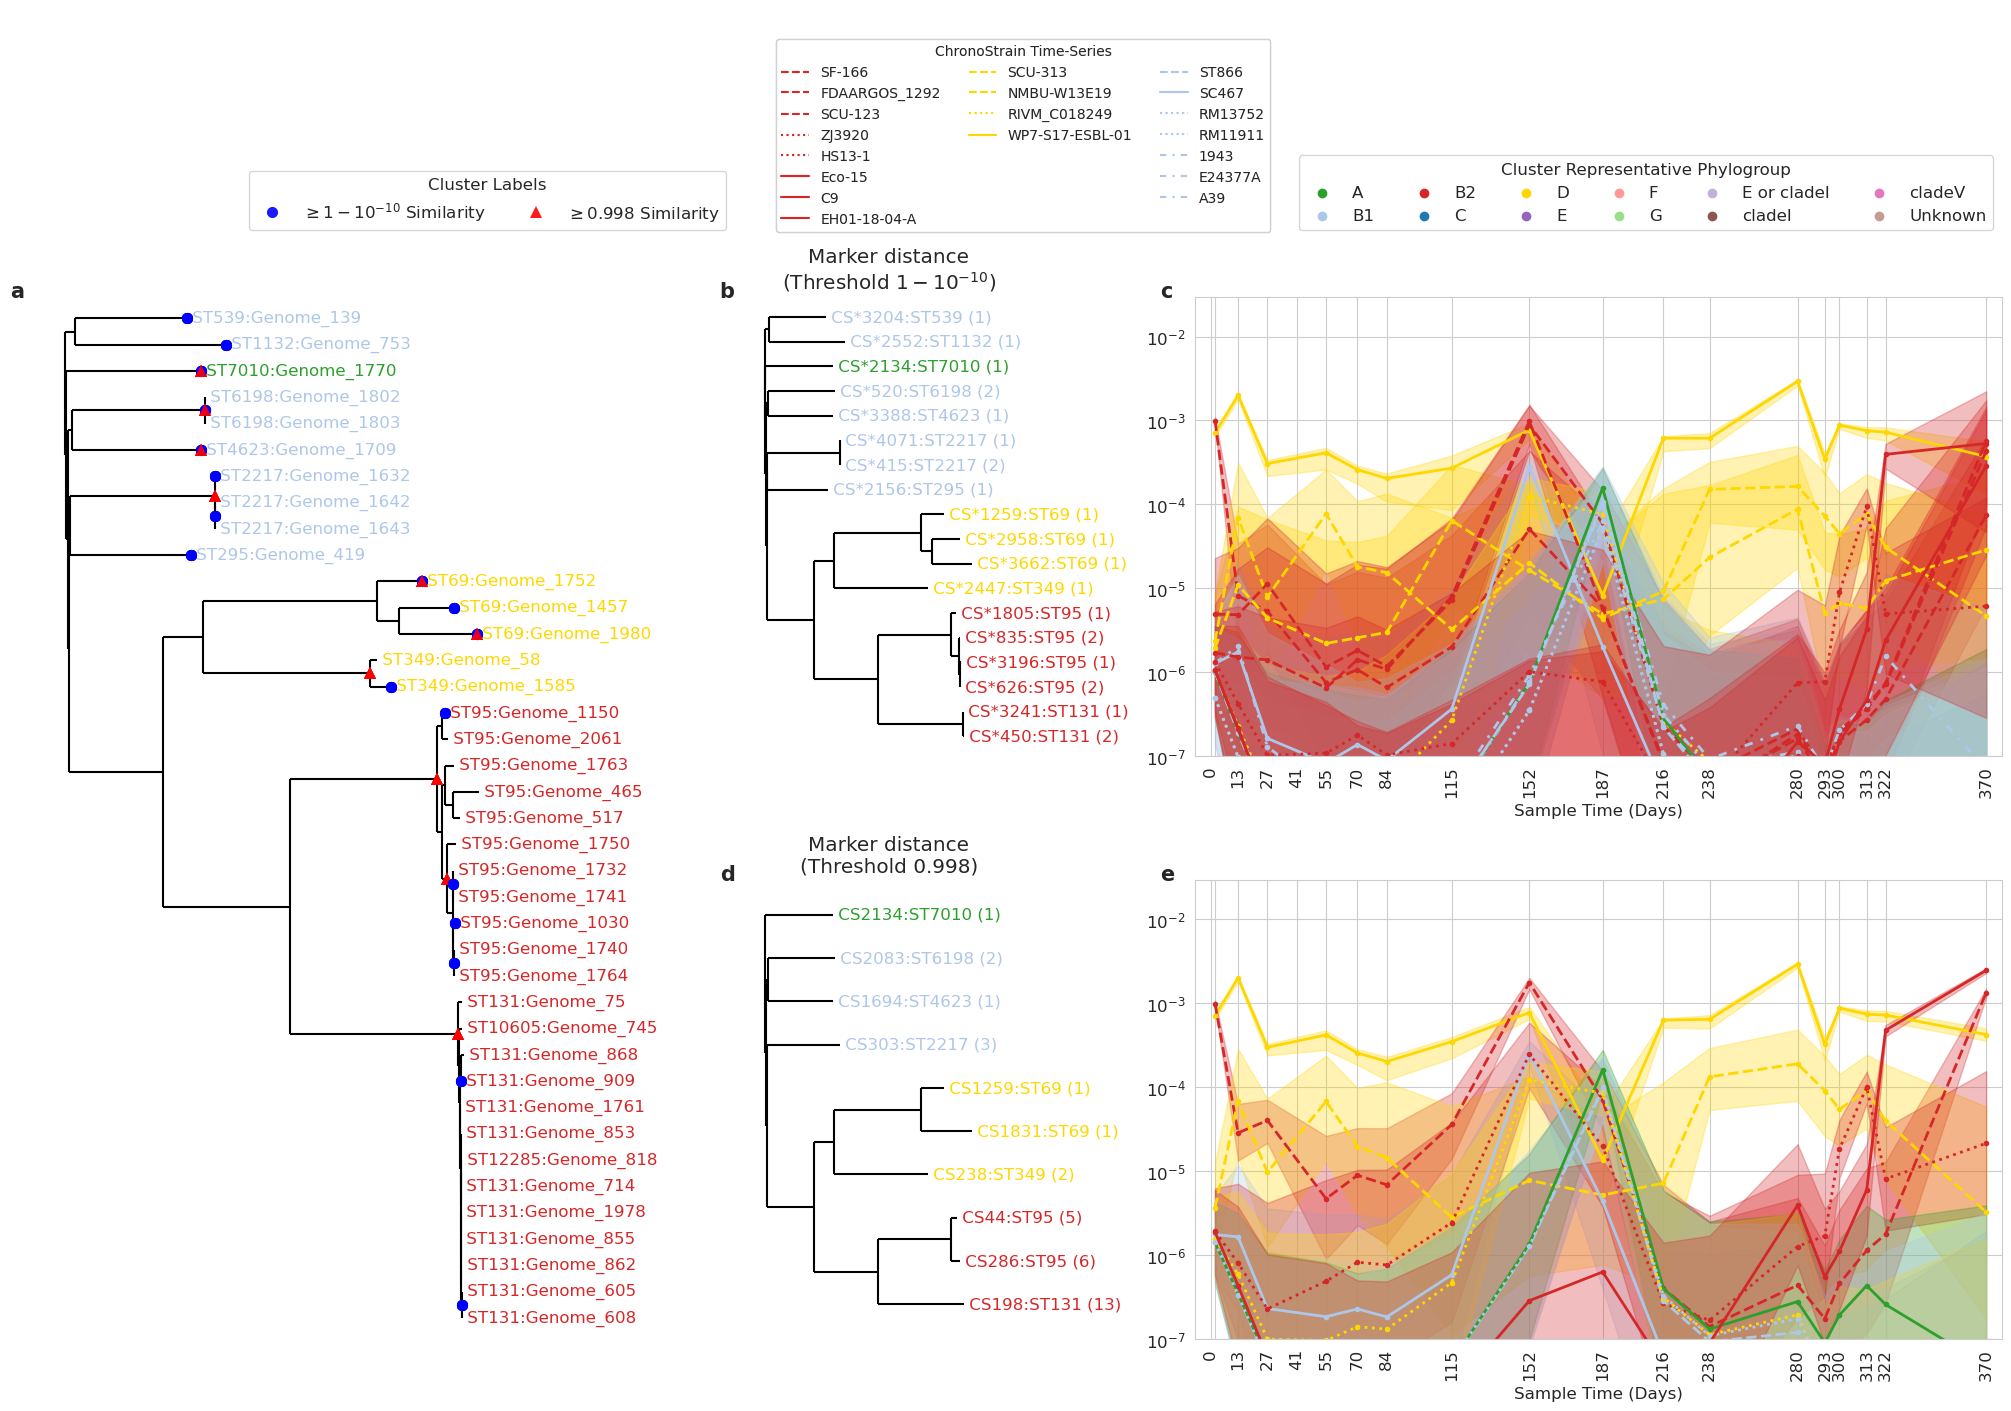

In [125]:
# from collections import defaultdict

seed = 31415
abund_lb = 0.05
width, height = (20, 14)
cfg.engine_cfg.prng_key = jax.random.PRNGKey(seed)  # for reproducibility

sb.set_style("whitegrid")
fig = plt.figure(constrained_layout=True, figsize=(width, height))
gs = gridspec.GridSpec(
    ncols=3, 
    nrows=1 + len(results_to_render), 
    figure=fig, 
    height_ratios=[1.] + [2] * len(results_to_render), 
    width_ratios=[2, 1, 3],
    hspace=0.01, wspace=0.01
)

result_axes = []
plotters = []
for p_idx, (pct, (res, cluster_path, render_name)) in enumerate(results_to_render.items()):
    if pct == 99.8:
        cluster_name_prefix = 'CS'
    if pct == 100.0:
        cluster_name_prefix = 'CS*'
        
    plotter = ChronostrainRendererCustom(
        db=db,
        abund_lb=abund_lb, 
        target_taxon=Taxon("Escherichia", "coli"), 
        strain_palette=strain_colors,
        stool_result=res,
        urine_result=None,
        plate_results=[],
        cluster_path=cluster_path,
        abx_df=load_abx_df('UMB18'),
        abx_palette=abx_colors,
        abx_label=abx_acronym,
        uti_df=load_uti_df('UMB18'),
        sample_df=load_sample_df('UMB18'),
        mlst_df=mlst_df,
        cluster_name_prefix=cluster_name_prefix
    )
    # ===== plot tree
    marker_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/tree.nwk"), "newick")
    marker_tree.ladderize()
    tree_ax = fig.add_subplot(gs[p_idx + 1, 1])
    x_posns, y_posns = plotter.plot_tree(
        ax=tree_ax,
        tree=marker_tree
    )
    tree_ax.set_title("Marker distance" + "\n" + "(Threshold " + render_name + ")")

    # ===== plot abundances
    abund_ax = fig.add_subplot(gs[p_idx + 1, 2])
    ymin, ymax = plotter.plot_overall_relabund(
        abund_ax, mode='stool', 
        strain_linestyles=custom_linestyles_red | custom_linestyles_yellow | custom_linestyles_lightblue
    )
    abund_ax.set_ylim(bottom=max(ymin, 1e-7), top=min(ymax*10, 1.0))

    # ==== update
    this_strain_ids = set(pd.unique(plotter.get_merged_df()['StrainId']))
    strain_ids_total = strain_ids_total.union(this_strain_ids)
    for s_id in this_strain_ids:
        members_total = members_total.union(set(plotter.clustering[s_id]))
    this_subtrees = [
        (plotter.clustering[s_id], tree_marker_styles[pct])
        for s_id in this_strain_ids
    ]

    subtrees = subtrees + this_subtrees
    plotter.set_xtick_times(abund_ax)
    result_axes.append(tree_ax)
    result_axes.append(abund_ax)
    plotters.append(plotter)
    abund_ax.set_xlabel('Sample Time (Days)')

# # ===================== Tree (Major)
print(strain_ids_total)
marker_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/tree.nwk"), "newick")
marker_tree.ladderize()
major_tree_ax = fig.add_subplot(gs[1:, 0])

index_df = pd.read_csv("/mnt/e/ecoli_db/ref_genomes/index.tsv", sep='\t')
# Create a unique index ID for each E. coli strain.
index_df = index_df.loc[
    (index_df['Genus'] == 'Escherichia') & (index_df['Species'] == 'coli')
]
index_df['EcoliID'] = list(range(index_df.shape[0]))


def genome_name_render(ecoli_strain_id: str):
    index_hit = index_df.loc[index_df['Accession'] == ecoli_strain_id]
    if index_hit.shape[0] == 0:
        raise Exception("Target strain id {} is not an E. coli genome.".format(ecoli_strain_id))
    else:
        ecoli_index_id = index_hit['EcoliID'].item()

    mlst_hit = mlst_df.loc[mlst_df['StrainId'] == ecoli_strain_id]
    if mlst_hit.shape[0] == 0:
        raise Exception("Target strain id {} didn't have an MLST output.".format(ecoli_strain_id))
    else:
        mlst_id = mlst_hit['MLST'].item()
    return '{}:Genome_{}'.format(mlst_id, ecoli_index_id)
    
strain_id_to_names = {
    # s_id: index_df.loc[index_df['Accession'] == s_id, 'Strain'].item() if s_id in strain_ids_total else ''  # only render cluster representatives
    s_id: genome_name_render(s_id)
    for s_id in members_total
}
strain_id_colors = {
    s_id: (
        phylo_colors[db.get_strain(s_id).phylogroup]
    )
    for s_id in members_total
}
_, _ = plot_subtree(
    major_tree_ax,
    strain_id_to_names=strain_id_to_names,
    strain_id_colors=strain_id_colors,
    tree=marker_tree,
    subtrees_with_colors=subtrees
)

# ===================== figure labels (a,b,c,d, etc)
add_figure_labels(
    fig, 
    [major_tree_ax] + result_axes
)


# ======================= tree legend
legend_ax = fig.add_subplot(gs[0, :])
legend_ax.axis('off')
handles = []
labels = []
for pct_key, style in tree_marker_styles.items():
    # point = plt.plot([], [], **style) # plotting single point via scatter
    _, _, pct_str = results_to_render[pct_key]
    point = matplotlib.lines.Line2D([], [], linestyle='', **style)
    handles.append(point)
    labels.append(r"$\geq$" + "{} Similarity".format(pct_str))

tree_node_legend = plt.legend(handles, labels, title="Cluster Labels", bbox_to_anchor=(0.1, 0.0), loc="lower left", ncol=6)
legend_ax.add_artist(tree_node_legend)


# ====================== Phylogroup legend
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=phylo_colors[p]), p) 
    for p in ['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G', 'E or cladeI', 'cladeI', 'cladeV', 'Unknown']
])
phylogroup_legend = plt.legend(handles, labels, title="Cluster Representative Phylogroup", bbox_to_anchor=(1., 0.0), loc="lower right", ncol=6)
legend_ax.add_artist(phylogroup_legend)

# ======== linestyle legend
def render_linestyle_custom_legend(linestyle_dicts: List[Dict], style_ax, title):    
    style_ax.axis('off')
    handles = []
    labels = []
    empty_legend_handle = matplotlib.lines.Line2D([], [], marker='None', linestyle='None')
    
    plt.rcParams.update({'font.size': 10})
    n_items_per = np.max([len(d) for d in linestyle_dicts])
    for custom_linestyles_category in linestyle_dicts:
        for s_id, s_style in custom_linestyles_category.items():
            s_name = index_df.loc[index_df['Accession'] == s_id, 'Strain'].head(1).item()
            c = strain_colors[s_id]
            line = matplotlib.lines.Line2D([], [], color=c, **s_style)
            handles.append(line)
            labels.append(s_name)
        
        # Filler: for spacing each category equally.
        for _ in range(n_items_per - len(custom_linestyles_category)):
            handles.append(empty_legend_handle)
            labels.append("")
    
    style_legend = plt.legend(handles, labels, title=title, bbox_to_anchor=(0.5, 0.0), loc="lower center", ncol=len(linestyle_dicts))
    style_ax.add_artist(style_legend)
    plt.rcParams.update({'font.size': 12})
    
render_linestyle_custom_legend([custom_linestyles_red, custom_linestyles_yellow, custom_linestyles_lightblue], legend_ax, title='ChronoStrain Time-Series')


# ======= Clean up and save to file.
del plotters
plt.savefig("plots/UMB18_granularity_comparison.pdf", transparent=True, bbox_inches='tight')